# Time series - multivariate prediction, LSTM for continuous prediction

In this example we will load prepared data and try to predict it with a lstm network producing continuous prediction

This example is very similar to the last lstm example except the model is trained to predict one step into the future that can be used for latter predictions.

In [1]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import os
from datetime import date
import re

import matplotlib.pyplot as plt

import pandas as pd
pd.options.display.max_rows = 30
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

TensorFlow 2.x selected.


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
PATH = '/content/drive/My Drive/ml-college/time-series-analysis/data/weather/ts_temp_dp_press.p'
training_df = pd.read_pickle(PATH)

Notice that we would randomly sample the training data from the whole weather history.

The `indices` array will contain starting date for each sample

In [0]:
import random

PREDICTION_LEN = 7
HISTORY_LEN = 14
NUM_SAMPLES = 2000
NUM_INPUTS = len(training_df.columns)

indices = random.sample(range(0,len(training_df) - HISTORY_LEN - 1), NUM_SAMPLES)

In this example the target sequence is shifted one step into the future. The model need to accumulate information in its inner state to correctly predict it.

Both input and output tensors remain in sequence form.

In [0]:
ts_data = training_df.values
ts_inputs = np.array([ts_data[i:i + HISTORY_LEN] for i in indices])
ts_outputs = np.array([ts_data[i + 1: i + 1 + HISTORY_LEN] for i in indices])

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, GRU, Input, Dense

inputs = Input(shape=ts_inputs.shape[1:])
x = GRU(64, return_sequences=True, recurrent_activation='sigmoid')(inputs)
x = GRU(32, return_sequences=True, recurrent_activation='sigmoid')(x)
outputs = Dense(NUM_INPUTS)(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 4)]           0         
_________________________________________________________________
gru (GRU)                    (None, 14, 64)            13440     
_________________________________________________________________
gru_1 (GRU)                  (None, 14, 32)            9408      
_________________________________________________________________
dense (Dense)                (None, 14, 4)             132       
Total params: 22,980
Trainable params: 22,980
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(ts_inputs, ts_outputs, validation_split=0.1, epochs=100)

Train on 1800 samples, validate on 200 samples
Epoch 1/100
1800/1800 [==============================] - 8s 4ms/sample - loss: 0.1043 - val_loss: 0.0714
Epoch 2/100
1800/1800 [==============================] - 1s 360us/sample - loss: 0.0658 - val_loss: 0.0608
Epoch 3/100
1800/1800 [==============================] - 1s 357us/sample - loss: 0.0590 - val_loss: 0.0568
Epoch 4/100
1800/1800 [==============================] - 1s 356us/sample - loss: 0.0562 - val_loss: 0.0548
Epoch 5/100
1800/1800 [==============================] - 1s 359us/sample - loss: 0.0546 - val_loss: 0.0537
Epoch 6/100
1800/1800 [==============================] - 1s 367us/sample - loss: 0.0536 - val_loss: 0.0537
Epoch 7/100
1800/1800 [==============================] - 1s 360us/sample - loss: 0.0532 - val_loss: 0.0526
Epoch 8/100
1800/1800 [==============================] - 1s 356us/sample - loss: 0.0526 - val_loss: 0.0520
Epoch 9/100
1800/1800 [==============================] - 1s 360us/sample - loss: 0.0521 - val_loss:

In [0]:
model.save_weights('model_plus1_predition.h5')

In [13]:
inputs = Input(batch_shape=(1, 1, NUM_INPUTS))
x = GRU(64, return_sequences=True, stateful=True)(inputs)
x = GRU(32, return_sequences=True, stateful=True)(x)
outputs = Dense(NUM_INPUTS)(x)

pred_model = Model(inputs, outputs)
pred_model.summary()
pred_model.load_weights('model_plus1_predition.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(1, 1, 4)]               0         
_________________________________________________________________
gru_4 (GRU)                  (1, 1, 64)                13440     
_________________________________________________________________
gru_5 (GRU)                  (1, 1, 32)                9408      
_________________________________________________________________
dense_2 (Dense)              (1, 1, 4)                 132       
Total params: 22,980
Trainable params: 22,980
Non-trainable params: 0
_________________________________________________________________


## Prediction phase

To test the prediction, we will take a particular date and feed the history into the network.

The network will predict one step into the future and we will take this prediction and feed it back to the network. In this way, we can predict multiple (and variable) steps into the future

Notice that the model is `stateful` i.e. the hidden state does not reset after the prediction.

In [0]:
import datetime
from datetime import timedelta

In [0]:
prediction_date = date(2014, 12, 23)

prediction_input = training_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date]

pred_model.reset_states()
for i in range(0, HISTORY_LEN):
    prediction = pred_model.predict(prediction_input.values[i].reshape(1, 1, NUM_INPUTS))
    
self_predicition = [np.copy(prediction)]

for i in range(0, PREDICTION_LEN - 1):
    prediction = pred_model.predict(self_predicition[i])
    self_predicition.append(np.copy(prediction))
    


history = training_df[prediction_date - timedelta(days=HISTORY_LEN - 1): prediction_date + timedelta(days=PREDICTION_LEN)]
prediction_df = pd.DataFrame(np.vstack(self_predicition).reshape((PREDICTION_LEN, NUM_INPUTS)), index=pd.date_range(start=prediction_date + timedelta(days=1), freq='D', periods=PREDICTION_LEN))


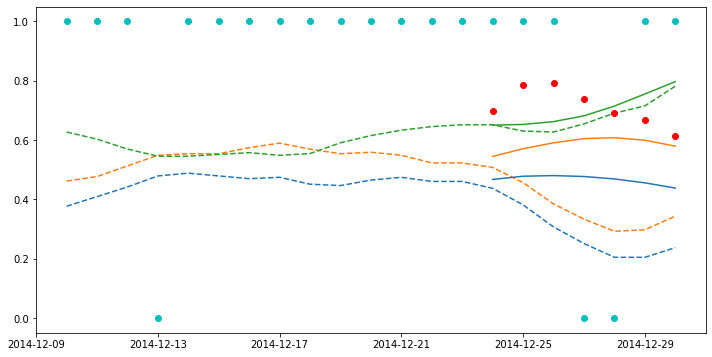

In [16]:
plt.figure(figsize = (12, 6))
history_plt = plt.plot(history.iloc[:,0:3], linestyle='--')
plt.plot(history.iloc[:,3], 'oc')
plt.plot(prediction_df.iloc[:,0], color=history_plt[0].get_color())
plt.plot(prediction_df.iloc[:,1], color=history_plt[1].get_color())
plt.plot(prediction_df.iloc[:,2], color=history_plt[2].get_color())
plt.plot(prediction_df.iloc[:,3], 'or')
plt.show()